In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
import joblib
import matplotlib.pyplot as plt

In [33]:
def fit_models(X, y):
    """
    Fit Ridge, Lasso, and ElasticNet models to the data and evaluate their performance.

    Parameters:
    X (np.ndarray): Feature matrix.
    y (np.ndarray): Target vector.

    Returns:
    dict: R-squared values for each model.
    ElasticNetCV: Fitted ElasticNet model.
    """
    results = {}

    # Fit the Ridge regression model with manual cross-validation
    ridge_alphas = np.logspace(-6, 6, 13)
    ridge_cv_scores = [cross_val_score(Ridge(alpha=alpha, max_iter=10000), X, y, cv=5).mean() for alpha in ridge_alphas]
    best_ridge_alpha = ridge_alphas[np.argmax(ridge_cv_scores)]
    ridge_model = Ridge(alpha=best_ridge_alpha, max_iter=10000)
    ridge_model.fit(X, y)
    results['Ridge'] = ridge_model.score(X, y)

    # Fit the Lasso regression model with cross-validation
    lasso_model = LassoCV(alphas=np.logspace(-6, 6, 13), cv=5, max_iter=10000)
    lasso_model.fit(X, y)
    results['Lasso'] = lasso_model.score(X, y)

    # Fit the ElasticNet regression model with cross-validation
    elasticnet_model = ElasticNetCV(alphas=np.logspace(-6, 6, 13), l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, max_iter=10000)
    elasticnet_model.fit(X, y)
    results['ElasticNet'] = elasticnet_model.score(X, y)

    return results, elasticnet_model

In [34]:
# Load prepared data
prepared_data = pd.read_csv('data/processed/prepared_data.csv')

In [35]:
# Define the features and target
features = prepared_data.columns.tolist()
features.remove('W')
X = prepared_data[features]
y = prepared_data['W']

In [36]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

In [38]:
# Fit models and evaluate performance
results, elasticnet_model = fit_models(X_poly, y)

In [39]:
# Print the R-squared values
for model_name, r_squared in results.items():
    print(f'R-squared for {model_name} regression: {r_squared:.2%}')

R-squared for Ridge regression: 40.91%
R-squared for Lasso regression: 73.19%
R-squared for ElasticNet regression: 98.56%


In [40]:
# Save the ElasticNet model
joblib.dump(elasticnet_model, 'models/elasticnet_model.joblib')

['models/elasticnet_model.joblib']

In [41]:
# Save the ElasticNet model coefficients
feature_names = poly.get_feature_names_out(features)
coefficients = elasticnet_model.coef_
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coeff_df.to_csv('data/processed/elasticnet_coefficients.csv', index=False)
print("Modeling completed. Model and coefficients saved.")

Modeling completed. Model and coefficients saved.


In [42]:
# Visualize the coefficients
coeff_df['abs_Coefficient'] = coeff_df['Coefficient'].abs()
sorted_coeff_df = coeff_df.sort_values(by='abs_Coefficient', ascending=False)
top_10_features = sorted_coeff_df.head(10)

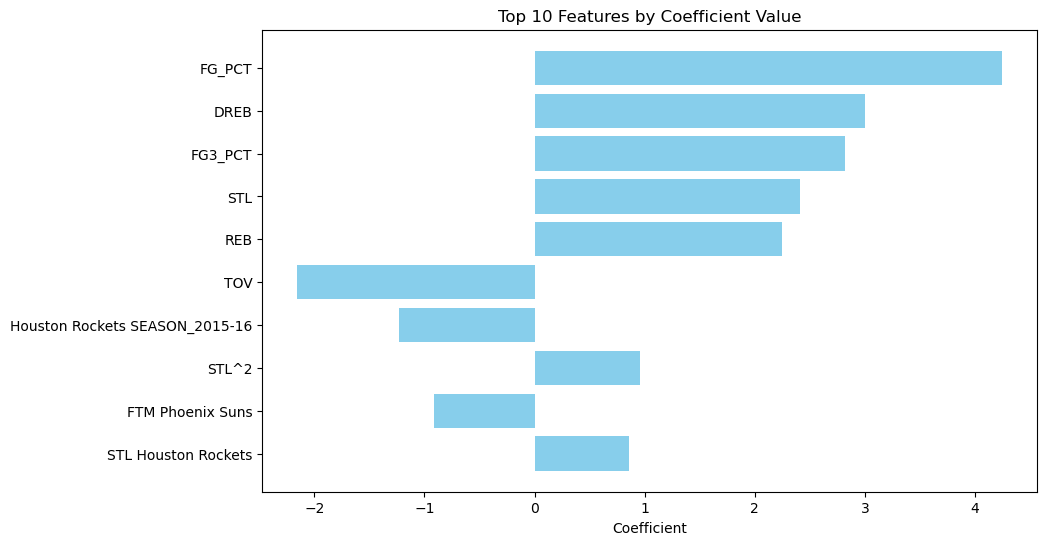

In [43]:
# Visualize the top features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Top 10 Features by Coefficient Value')
plt.gca().invert_yaxis()
plt.savefig('visualizations/top_10_features.png')
plt.show()